In [15]:
import os
import xarray as xr
import xdggs
import zarr
import geopandas as gpd
os.environ['DGGRID_PATH']='/home/dick/micromamba/envs/xdggs/bin/dggrid'
from xdggs_dggrid4py.regridding import igeo7regridding
from xdggs_dggrid4py.IGEO7 import IGEO7Index
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore")

## A simple step by step howto
This notebook showcases converting a 2D array dataset to a 1D dataset with DGGS (IGEO7) as an index. 
- prepare data
- conversion from 2D coordinates to DGGS cell id
- some use cases on DGGS

### Prepare Data

In [2]:
# data source : https://data.opendatascience.eu/geonetwork/srv/eng/catalog.search#/metadata/356923ff-88a1-4770-8bc7-3de7584079be
data = xr.open_dataset("https://s3.eu-central-1.wasabisys.com/eumap/aq/aq_pm25_et.eml_m_1km_na_201812_eumap_epsg3035_v0.1prebeta.tif", band_as_variable=True, engine='rasterio')
data

<xarray.Dataset> Size: 54MB
Dimensions:      (x: 3472, y: 3857)
Coordinates:
  * x            (x) float64 28kB 2.542e+06 2.544e+06 ... 6.012e+06 6.014e+06
  * y            (y) float64 31kB 5.418e+06 5.416e+06 ... 1.562e+06 1.562e+06
    spatial_ref  int64 8B ...
Data variables:
    band_1       (y, x) float32 54MB ...
Attributes:
    SCALE_FACTOR:   0.01
    AREA_OR_POINT:  Area

We need to specify the attributes of DGGS for conversion; the content varies from different DGGS.
The full attributes content of IGEO7 is :
```python
    {    "grid_name": "igeo7",  
             "level": -1,  # you can specify the required resolution here.
                           # or -1 to calculate the resoultion automically
          "src_epsg": "EPSG:3035", # the epsg of the data, you may need to change it.
           "method" : "nearestpoint", # method that will be use for regridding. (centerpoint , nearestpoint)
       "coordinate" : ["x","y"], # what are the coordinate dimension in the xarray.
               "mp" : 6, # for multiprocessing, number of process that you want to use
             "chunk" : (200,200), # block size, when given, the whole extent will be processed in smaller blocks.
                                  # default to whole extent. 
    }
```
After that, we assign the attributes to one of the current coordinates, for this example, either x or y.

In [3]:
attrs={"grid_name": "igeo7",
        "level": -1,
        "src_epsg": "EPSG:3035",
        "method" : "nearestpoint",
        "coordinate" : ["x","y"],
        "chunk": (200,200),
        "mp": 6}
data['y'].attrs=attrs

### Conversion from 2D coordinates to DGGS cell id
To peform the conversion, we use the `igeo7regridding` function to create a new index. It will select the regridding method from the `attrs['method']` that is loaded as a plugin.

Notes on performance: 
- with size of 3472 x 3875 pixels and resoultion 9
- Conversion time with whole extent , mp=1 is 8mins (6GB Ram)
- Conversion time with chunk (200x200), mp =6  is 1.5mins (1.5~2GB Ram)

In [4]:
%%time
dggs_data = igeo7regridding(data)

c1 shape: ((3472,)), c2 shape: ((3857,))
Calculate Auto resolution
Total Bounds (EPSG:3035): [2542500. 1561500. 6013500. 5417500.]
Total Bounds (wgs84): [-33.13136656  35.06597435  51.54843604  67.09363937]
Total Bounds Area (km^2): 20793600.108343568
Area per center point (km^2): 1.5527456892327829
Auto resolution : 9, area: 1.2639902 km2
--- Multiprocessing 6, jobs: 360, job size: 40000, chunk: (200, 200)  ---
--- Generate cells ID at level 9 by nearestpoint


  0%|          | 0/360 [00:00<?, ?it/s]

Re-assign data to cells, number of cells: 10589985, not assigned: 3242197, reused: 396630


  0%|          | 0/360 [00:00<?, ?it/s]

---Generation completed time: (88.9557237625122), number of cells: 10589985, unique cell id:10555261 ---
Re-assign data completed
CPU times: user 3.28 s, sys: 1.96 s, total: 5.25 s
Wall time: 1min 30s


After conversion, the dataset is transformed into one dimension, as shown below. 

To use xdggs with the converted dataset , use `xdggs.decode` function to create the IGEO7Index with the cell_ids coordinates

In [10]:
dggs_data = xdggs.decode(dggs_data)
dggs_data

<xarray.Dataset> Size: 127MB
Dimensions:      (cell_ids: 10589985)
Coordinates:
    spatial_ref  int64 8B ...
  * cell_ids     (cell_ids) object 85MB '00562316206' ... '00324336444'
Data variables:
    band_1       (cell_ids) float32 42MB nan nan nan nan nan ... nan nan nan nan
Indexes:
    cell_ids  ISEAIndex(grid_name=IGEO7, level=9)
Attributes:
    SCALE_FACTOR:   0.01
    AREA_OR_POINT:  Area

We can use `xarray.to_zarr()` to make the dataset persistent on either local/cloud storage.

But when we load the dataset from the disk again, the index will be loaded as PandasIndex.

We can again using the `xdggs.decode` function to re-initialize it to the IGEO7 index.

In [11]:
# save it to zarr
compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)
dggs_data.to_zarr(f'dggs_data.zar',encoding={"band_1": {"compressor": compressor},"cell_ids": {"compressor": compressor}})

dggs_zarr = xr.open_zarr('./dggs_data.zar')
dggs_zarr

<xarray.Dataset> Size: 127MB
Dimensions:      (cell_ids: 10589985)
Coordinates:
  * cell_ids     (cell_ids) object 85MB '00562316206' ... '00324336444'
Data variables:
    band_1       (cell_ids) float32 42MB dask.array<chunksize=(165469,), meta=np.ndarray>
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:  Area
    SCALE_FACTOR:   0.01

In [12]:
dggs_zarr = xdggs.decode(dggs_zarr) 
dggs_zarr

<xarray.Dataset> Size: 127MB
Dimensions:      (cell_ids: 10589985)
Coordinates:
  * cell_ids     (cell_ids) object 85MB '00562316206' ... '00324336444'
Data variables:
    band_1       (cell_ids) float32 42MB dask.array<chunksize=(165469,), meta=np.ndarray>
    spatial_ref  int64 8B ...
Indexes:
    cell_ids  ISEAIndex(grid_name=IGEO7, level=9)
Attributes:
    AREA_OR_POINT:  Area
    SCALE_FACTOR:   0.01

In [13]:
# some basic operation on the xarray with xdggs 
dggs_zarr.dggs.sel_latlon(latitude=[44.56375059,44.56369803],longitude=[6.68935115])

<xarray.Dataset> Size: 20B
Dimensions:      (cell_ids: 1)
Coordinates:
  * cell_ids     (cell_ids) object 8B '00615065526'
Data variables:
    band_1       (cell_ids) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    spatial_ref  int64 8B ...
Indexes:
    cell_ids  ISEAIndex(grid_name=IGEO7, level=9)
Attributes:
    AREA_OR_POINT:  Area
    SCALE_FACTOR:   0.01

In [14]:
# generate cell's centroids for selected cellids , if not given, generate all.
# return a data_array
dggs_zarr.dggs.cell_centers()

  0%|          | 0/52950 [00:00<?, ?it/s]

<xarray.Dataset> Size: 85MB
Dimensions:    (cell_ids: 10589985)
Coordinates:
    latitude   (cell_ids) float32 42MB 65.84 65.83 65.82 ... 35.41 35.42 35.41
    longitude  (cell_ids) float32 42MB -28.16 -28.17 -28.21 ... 27.85 27.85
Dimensions without coordinates: cell_ids
Data variables:
    *empty*

In [16]:
# generate cell's polygon for selected cellids , if not given, generate all.
# return a data_array , becare of memory usage, polygons are return as list of shapely object.
dggs_polygon = dggs_zarr.dggs.cell_boundaries()
# as it is a data array, we have to change it to dataset to merge with the data
dggs_polygon = dggs_polygon.to_dataset(name='polygon')
# before we merge, we have to create the IGEO7 index for the dggs_polygon, so that they got the same index class
dggs_polygon = xdggs.decode(dggs_polygon)
combine = xr.merge([dggs_zarr, dggs_polygon])

  0%|          | 0/52950 [00:00<?, ?it/s]

In [21]:
# plotting 
combine = combine.to_dataframe().reset_index()

<Axes: >

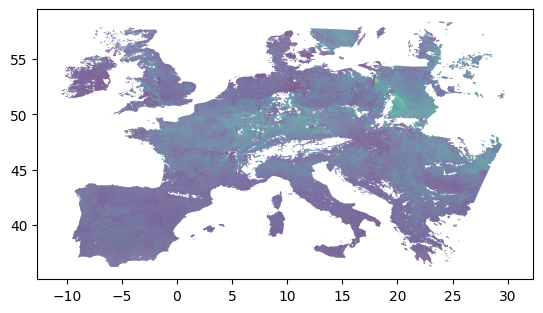

In [24]:
combine = combine.set_geometry('polygon')
combine.dropna().plot(column='band_1')